In [2]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import map_coordinates
from scipy.ndimage import gaussian_filter
from tqdm import tqdm
import os

In [3]:
# Load MNIST dataset
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

In [4]:
def batch_elastic_transform(images, sigma, alpha, height, width, random_state=None):
    """
    Elastic deformation of images as described in [Simard 2003].
    
    Args:
        images: a two-dimensional numpy array; list of flattened images
        sigma: variance of the gaussian kernel
        alpha: multiplier for the displacement fields
        height: image height
        width: image width
        random_state: numpy random state object
    
    Returns:
        elastically distorted images of the same shape
    """
    assert len(images.shape) == 2
    e_images = np.empty_like(images)
    e_images[:] = images
    
    e_images = e_images.reshape(-1, height, width)
    
    if random_state is None:
        random_state = np.random.RandomState(None)
    x, y = np.mgrid[0:height, 0:width]
    
    for i in range(e_images.shape[0]):
        dx = gaussian_filter((random_state.rand(height, width) * 2 - 1), 
                           sigma, mode='constant') * alpha
        dy = gaussian_filter((random_state.rand(height, width) * 2 - 1), 
                           sigma, mode='constant') * alpha
        indices = x + dx, y + dy
        e_images[i] = map_coordinates(e_images[i], indices, order=1)

    return e_images.reshape(-1, height*width)

In [5]:
random_state = np.random.RandomState(None)
dx1 = random_state.rand(28, 28) * 2 - 1
dy1 = random_state.rand(28, 28) * 2 - 1
dx2 = gaussian_filter(dx1, 4, mode='constant')
dy2 = gaussian_filter(dy1, 4, mode='constant')

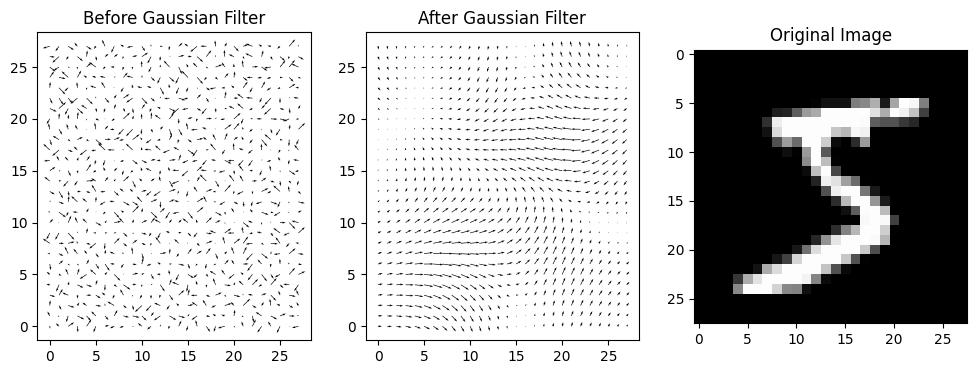

In [6]:
x, y = np.mgrid[0:28, 0:28]
    
plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.quiver(x, y, dx1, dy1)
plt.title('Before Gaussian Filter')
plt.subplot(132)
plt.quiver(x, y, dx2, dy2)
plt.title('After Gaussian Filter')
# Demonstrate elastic transform on MNIST image
img = x_train[0]
plt.subplot(133)
plt.imshow(img, cmap='gray')
plt.title('Original Image')
plt.show()

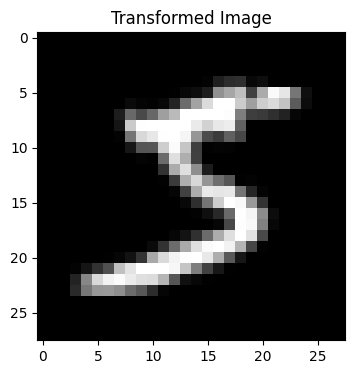

In [7]:
transformed_img = batch_elastic_transform(
    img.reshape(1, -1), 
    sigma=4, 
    alpha=20, 
    height=28, 
    width=28
)
    
plt.figure(figsize=(4, 4))
plt.imshow(transformed_img.reshape(28, 28), cmap='gray')
plt.title('Transformed Image')
plt.show()

In [8]:
def transform_dataset(x_train, batch_size=1000, sigma=4, alpha=20):
    """
    Transform entire dataset in batches to avoid memory issues
    """
    height, width = x_train.shape[1:]
    n_samples = x_train.shape[0]
    
    # Initialize array for transformed images
    transformed_images = np.zeros((n_samples, height * width))
    
    # Process in batches
    for i in tqdm(range(0, n_samples, batch_size)):
        batch_end = min(i + batch_size, n_samples)
        batch = x_train[i:batch_end]
        
        # Reshape batch to 2D array (n_samples, pixels)
        batch_flat = batch.reshape(batch_end - i, -1)
        
        # Apply transformation
        transformed = batch_elastic_transform(
            batch_flat, 
            sigma=sigma, 
            alpha=alpha,
            height=height,
            width=width
        )
        
        transformed_images[i:batch_end] = transformed
    
    return transformed_images

In [9]:
transformed_train = transform_dataset(x_train)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 60/60 [00:06<00:00,  9.92it/s]


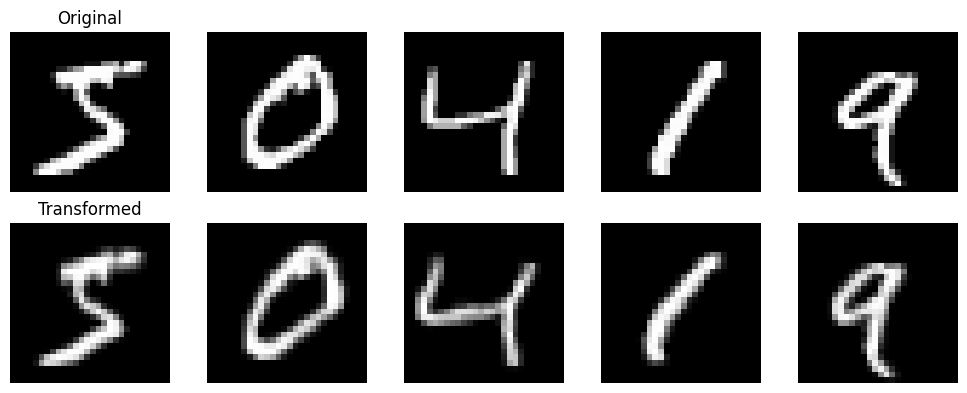

In [10]:
def plot_comparison(original, transformed, num_images=5):
    plt.figure(figsize=(2*num_images, 4))
    
    for i in range(num_images):
        # Original image
        plt.subplot(2, num_images, i + 1)
        plt.imshow(original[i], cmap='gray')
        plt.axis('off')
        if i == 0:
            plt.title('Original')
            
        # Transformed image
        plt.subplot(2, num_images, num_images + i + 1)
        plt.imshow(transformed[i].reshape(28, 28), cmap='gray')
        plt.axis('off')
        if i == 0:
            plt.title('Transformed')
    
    plt.tight_layout()
    plt.show()

# Plot some examples
plot_comparison(x_train, transformed_train)

In [19]:
class AttentionAutoencoder(tf.keras.Model):
    def __init__(self, input_shape, n_classes, **kwargs):
        super(AttentionAutoencoder, self).__init__(**kwargs)
        self.input_shape_ = input_shape
        self.n_classes = n_classes
        
        # Encoder layers
        self.encoder = tf.keras.Sequential([
            tf.keras.layers.InputLayer(input_shape=input_shape),
            tf.keras.layers.Conv2D(32, 3, strides=2, padding='same', activation='relu'),
            tf.keras.layers.Conv2D(32, 3, strides=2, padding='same', activation='relu'),
            tf.keras.layers.Conv2D(32, 3, strides=2, padding='same', activation='relu'),
            tf.keras.layers.Conv2D(10, 3, strides=1, padding='same', activation='relu'),
            tf.keras.layers.Flatten()
        ])

        self.downsize = tf.keras.layers.Dense(15)
        # Attention layers
        self.attention = tf.keras.layers.Attention()
        self.query_dense = tf.keras.layers.Dense(15)
        self.value_dense = tf.keras.layers.Dense(15)
        
        # Decoder layers
        self.decoder = tf.keras.Sequential([
            tf.keras.layers.InputLayer(shape=(15,)),
            tf.keras.layers.Dense(4*4*10),
            tf.keras.layers.Reshape((4, 4, 10)),
            tf.keras.layers.Conv2DTranspose(32, 3, strides=1, padding='valid', activation='relu'),  # 4x4x32
            tf.keras.layers.Conv2DTranspose(32, 3, strides=2, padding='same', activation='relu'),  # 8x8x32
            tf.keras.layers.Conv2DTranspose(32, 3, strides=1, padding='valid', activation='relu'),  # 14x14x32
            tf.keras.layers.Conv2DTranspose(1, 3, strides=2, padding='same', activation='sigmoid') # 28x28x1
        ])
        
        # Classification layer
        self.classifier = tf.keras.layers.Dense(n_classes)

        print(self.encoder.summary())
        print(self.decoder.summary())


    def call(self, inputs):
    # Ensure input shape is correct
        if len(inputs.shape) == 2:
            inputs = tf.reshape(inputs, [-1, 28, 28, 1])
        
        # Encode
        features = self.downsize(self.encoder(inputs))
        query = self.query_dense(features)
        value = self.value_dense(features)
    
        # Reshape query and value for attention mechanism
        query = tf.expand_dims(query, axis=1)  # Shape: (batch_size, 1, 15)
        value = tf.expand_dims(value, axis=1)  # Shape: (batch_size, 1, 15)
    
        # Apply attention
        attention_output = self.attention([query, value])
        
        # Calculate attention weights
        attention_weights = tf.matmul(query, tf.transpose(value, [0, 2, 1]))
        attention_weights = tf.nn.softmax(attention_weights,axis=-1)
        
        # Create attention map for visualization
        attention_map = tf.squeeze(attention_weights, axis=1)  # Shape: (batch_size, 15)
        attention_map = tf.expand_dims(attention_map, axis=-1)  # Shape: (batch_size, 15, 1)
        attention_map = tf.image.resize(attention_map, (28, 28))  # Shape: (batch_size, 28, 28, 1)
        
        attended_features = tf.squeeze(attention_output, axis=1)
        
        # Get logits
        logits = self.classifier(attended_features)
        
        # Decode
        decoded = self.decoder(features)
        
        return logits, decoded, features, attended_features, attention_map


    def get_config(self):
        config = super(AttentionAutoencoder, self).get_config()
        config.update({
            "input_shape": self.input_shape_,
            "n_classes": self.n_classes,
        })
        return config

    @classmethod
    def from_config(cls, config):
        input_shape = config.pop("input_shape", (28, 28, 1))  
        n_classes = config.pop("n_classes", 10)           
        return cls(input_shape=input_shape, n_classes=n_classes, **config)

In [20]:
# def train_step(model, optimizer, x, y, lambda_params):
#     with tf.GradientTape() as tape:
#         # Forward pass
#         x = tf.reshape(x, [-1, 28, 28, 1])
#         logits, decoded, features, attended_features, attention_weights = model(x)

#         # Calculate losses
#         y = tf.reshape(y, [-1, 10])
#         classification_loss = tf.reduce_mean(
#             tf.keras.losses.categorical_crossentropy(y, logits, from_logits=True)
#         )
#         x_flat = tf.reshape(x, [-1, 784])
#         decoded_flat = tf.reshape(decoded, [-1, 784])
        
#         reconstruction_loss = tf.reduce_mean(
#             tf.keras.losses.binary_crossentropy(x_flat, decoded_flat)
#         )
        
#         # Attention diversity loss - encourages diverse attention patterns
#         kl_loss = tf.keras.losses.KLDivergence()
#         uniform_dist = tf.ones_like(attention_weights) / tf.cast(tf.shape(attention_weights)[1], tf.float32)
#         attention_loss = kl_loss(uniform_dist, attention_weights)
        
#         # Total loss
#         total_loss = (lambda_params['class'] * classification_loss + 
#                      lambda_params['ae'] * reconstruction_loss +
#                      lambda_params['attention'] * attention_loss)
    
#     # Backpropagation
#     gradients = tape.gradient(total_loss, model.trainable_variables)
#     optimizer.apply_gradients(zip(gradients, model.trainable_variables))
#     return {
#         'classification': classification_loss,
#         'reconstruction': reconstruction_loss,
#         'attention': attention_loss,
#         'total': total_loss
#     }

def train_step(model, optimizer, x, y, lambda_params):
    with tf.GradientTape() as tape:
        # Forward pass
        x = tf.reshape(x, [-1, 28, 28, 1])
        logits, decoded, features, attended_features, attention_map = model(x)
        
        # Calculate losses
        y = tf.reshape(y, [-1, 10])
        classification_loss = tf.reduce_mean(
            tf.keras.losses.categorical_crossentropy(y, logits, from_logits=True)
        )
        x_flat = tf.reshape(x, [-1, 784])
        decoded_flat = tf.reshape(decoded, [-1, 784])
        
        reconstruction_loss = tf.reduce_mean(
            tf.keras.losses.binary_crossentropy(x_flat, decoded_flat)
        )
        
        # Attention diversity loss - update to work with the new attention_map
        attention_map_flat = tf.reshape(attention_map, [-1])
        uniform_dist = tf.ones_like(attention_map_flat) / tf.cast(tf.size(attention_map_flat), tf.float32)
        
        # Use KL divergence or entropy to encourage diversity
        kl_loss = tf.keras.losses.KLDivergence()
        attention_loss = kl_loss(uniform_dist, attention_map_flat)
        # attention_loss = tf.reduce_mean(tf.keras.losses.KLDivergence(uniform_dist, attention_map_flat))
        
        # Total loss
        total_loss = (lambda_params['class'] * classification_loss + 
                     lambda_params['ae'] * reconstruction_loss +
                     lambda_params['attention'] * attention_loss)
    
    # Backpropagation
    gradients = tape.gradient(total_loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return {
        'classification': classification_loss,
        'reconstruction': reconstruction_loss,
        'attention': attention_loss,
        'total': total_loss
    }

In [21]:
def visualize_reconstructions(model, dataset):
    # Get multiple batches of images and select diverse samples
    sample_images = []
    for x_batch, _ in dataset.take(5):
        # Select 2 random images from each batch
        indices = tf.random.shuffle(tf.range(x_batch.shape[0]))[:2]
        sample_images.extend(tf.gather(x_batch, indices))
        if len(sample_images) >= 10:
            break
    
    sample_images = tf.stack(sample_images[:10])
    sample_images = tf.reshape(sample_images, [-1, 28, 28, 1])  # Ensure 4D shape
    
    # Reconstruct images
    _, reconstructed, _, _, _ = model(sample_images)
    
    # Plot results
    fig, axes = plt.subplots(2, 10, figsize=(20, 4))
    plt.suptitle('Original Images (top) vs Reconstructed Images (bottom)', y=1.05)
    
    for i in range(10):
        # Ensure proper shape for visualization
        orig_img = tf.squeeze(sample_images[i]).numpy()
        recon_img = tf.squeeze(reconstructed[i]).numpy()
        
        axes[0, i].imshow(orig_img, cmap='gray')
        axes[0, i].axis('off')
        axes[1, i].imshow(recon_img, cmap='gray')
        axes[1, i].axis('off')
    
    plt.tight_layout()
    plt.show()

In [22]:
def train_model(model, train_dataset, valid_dataset, test_dataset, epochs=1500, 
                learning_rate=0.002, batch_size=250, log_dir="logs"):
    
    optimizer = tf.keras.optimizers.Adam(learning_rate)
    lambda_params = {'class': 20, 'ae': 1, 'attention': 0.1}
    
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs} ")
        
        # Training loop
        for x_batch, y_batch in train_dataset:
            # Apply elastic transform
            x_batch = tf.reshape(x_batch, [-1, 28, 28, 1])
            x_flat = tf.reshape(x_batch, [-1, 784])
            x_batch_elastic = batch_elastic_transform(x_flat, sigma=4, alpha=20, 
                                                    height=28, width=28)
            losses = train_step(model, optimizer, x_batch_elastic, y_batch, lambda_params)
        
        # Validation
        val_accuracy = tf.keras.metrics.CategoricalAccuracy()
        for x_val, y_val in valid_dataset:
            logits, *_ = model(x_val)  # Use *_ to ignore other returned values
            val_accuracy.update_state(y_val, logits)
        
        print(f"Validation accuracy: {val_accuracy.result():.4f}, Loss: {losses}\n")

In [15]:
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)

In [16]:
# Create datasets
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(250)
valid_dataset = tf.data.Dataset.from_tensor_slices((x_test[:5000], y_test[:5000])).batch(250)
test_dataset = tf.data.Dataset.from_tensor_slices((x_test[5000:], y_test[5000:])).batch(250)

2024-12-14 23:20:00.072876: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-12-14 23:20:00.072907: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-12-14 23:20:00.072966: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-12-14 23:20:00.073014: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-12-14 23:20:00.073058: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [23]:
# Create and train model
model = AttentionAutoencoder(input_shape=(28, 28, 1), n_classes=10)

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 14, 14, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 7, 7, 32)       │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 4, 4, 32)       │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 4, 4, 10)       │         2,890 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 160)            │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,706 (84.79 KB)

 Trainable params: 21,706 (84.79 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_8 (Dense)                 │ (None, 160)            │         2,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 4, 4, 10)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_4              │ (None, 6, 6, 32)       │         2,912 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_5              │ (None, 12, 12, 32)     │         9,248 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_6              │ (None, 14, 14, 32)     │         9,248 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_7              │ (None, 28, 28, 1)      │           289 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,257 (94.75 KB)

 Trainable params: 24,257 (94.75 KB)

 Non-trainable params: 0 (0.00 B)

None


In [ ]:
train_model(model, train_dataset, valid_dataset, test_dataset,epochs=150)

Epoch 1/150 


2024-12-14 23:25:40.536500: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-14 23:25:40.928484: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.9408, Loss: {'classification': <tf.Tensor: shape=(), dtype=float32, numpy=0.1705316>, 'reconstruction': <tf.Tensor: shape=(), dtype=float32, numpy=0.20292182>, 'attention': <tf.Tensor: shape=(), dtype=float32, numpy=-6.6644096>, 'total': <tf.Tensor: shape=(), dtype=float32, numpy=2.947113>}

Epoch 2/150 


2024-12-14 23:26:17.604633: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-14 23:26:18.004415: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.9638, Loss: {'classification': <tf.Tensor: shape=(), dtype=float32, numpy=0.16358945>, 'reconstruction': <tf.Tensor: shape=(), dtype=float32, numpy=0.1904616>, 'attention': <tf.Tensor: shape=(), dtype=float32, numpy=-6.6644096>, 'total': <tf.Tensor: shape=(), dtype=float32, numpy=2.7958097>}

Epoch 3/150 


2024-12-14 23:26:54.908371: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-14 23:26:55.396366: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.9690, Loss: {'classification': <tf.Tensor: shape=(), dtype=float32, numpy=0.17275254>, 'reconstruction': <tf.Tensor: shape=(), dtype=float32, numpy=0.18269494>, 'attention': <tf.Tensor: shape=(), dtype=float32, numpy=-6.6644096>, 'total': <tf.Tensor: shape=(), dtype=float32, numpy=2.971305>}

Epoch 4/150 


2024-12-14 23:27:33.369733: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-14 23:27:33.857096: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.9728, Loss: {'classification': <tf.Tensor: shape=(), dtype=float32, numpy=0.18555355>, 'reconstruction': <tf.Tensor: shape=(), dtype=float32, numpy=0.18051912>, 'attention': <tf.Tensor: shape=(), dtype=float32, numpy=-6.6644096>, 'total': <tf.Tensor: shape=(), dtype=float32, numpy=3.2251492>}

Epoch 5/150 


2024-12-14 23:28:11.139346: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-14 23:28:11.536159: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.9764, Loss: {'classification': <tf.Tensor: shape=(), dtype=float32, numpy=0.13682632>, 'reconstruction': <tf.Tensor: shape=(), dtype=float32, numpy=0.17532134>, 'attention': <tf.Tensor: shape=(), dtype=float32, numpy=-6.6644096>, 'total': <tf.Tensor: shape=(), dtype=float32, numpy=2.2454069>}

Epoch 6/150 


2024-12-14 23:28:51.178676: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-14 23:28:51.577505: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.9788, Loss: {'classification': <tf.Tensor: shape=(), dtype=float32, numpy=0.117923975>, 'reconstruction': <tf.Tensor: shape=(), dtype=float32, numpy=0.17786106>, 'attention': <tf.Tensor: shape=(), dtype=float32, numpy=-6.6644096>, 'total': <tf.Tensor: shape=(), dtype=float32, numpy=1.8698995>}

Epoch 7/150 


2024-12-14 23:29:28.990495: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-14 23:29:29.396113: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.9760, Loss: {'classification': <tf.Tensor: shape=(), dtype=float32, numpy=0.14844465>, 'reconstruction': <tf.Tensor: shape=(), dtype=float32, numpy=0.17640558>, 'attention': <tf.Tensor: shape=(), dtype=float32, numpy=-6.6644096>, 'total': <tf.Tensor: shape=(), dtype=float32, numpy=2.4788578>}

Epoch 8/150 


2024-12-14 23:30:09.238752: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-14 23:30:09.644681: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.9782, Loss: {'classification': <tf.Tensor: shape=(), dtype=float32, numpy=0.117391616>, 'reconstruction': <tf.Tensor: shape=(), dtype=float32, numpy=0.17301017>, 'attention': <tf.Tensor: shape=(), dtype=float32, numpy=-6.6644096>, 'total': <tf.Tensor: shape=(), dtype=float32, numpy=1.8544014>}

Epoch 9/150 


2024-12-14 23:30:48.853593: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-14 23:30:49.250872: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.9794, Loss: {'classification': <tf.Tensor: shape=(), dtype=float32, numpy=0.09847036>, 'reconstruction': <tf.Tensor: shape=(), dtype=float32, numpy=0.17309587>, 'attention': <tf.Tensor: shape=(), dtype=float32, numpy=-6.6644096>, 'total': <tf.Tensor: shape=(), dtype=float32, numpy=1.476062>}

Epoch 10/150 


2024-12-14 23:31:25.471296: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-14 23:31:25.876123: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.9828, Loss: {'classification': <tf.Tensor: shape=(), dtype=float32, numpy=0.15715706>, 'reconstruction': <tf.Tensor: shape=(), dtype=float32, numpy=0.17243235>, 'attention': <tf.Tensor: shape=(), dtype=float32, numpy=-6.6644096>, 'total': <tf.Tensor: shape=(), dtype=float32, numpy=2.6491327>}

Epoch 11/150 


2024-12-14 23:32:05.425923: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-14 23:32:05.855403: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.9828, Loss: {'classification': <tf.Tensor: shape=(), dtype=float32, numpy=0.12971315>, 'reconstruction': <tf.Tensor: shape=(), dtype=float32, numpy=0.17206849>, 'attention': <tf.Tensor: shape=(), dtype=float32, numpy=-6.6644096>, 'total': <tf.Tensor: shape=(), dtype=float32, numpy=2.0998907>}

Epoch 12/150 


2024-12-14 23:32:41.444031: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-14 23:32:41.827434: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.9848, Loss: {'classification': <tf.Tensor: shape=(), dtype=float32, numpy=0.07862763>, 'reconstruction': <tf.Tensor: shape=(), dtype=float32, numpy=0.17405485>, 'attention': <tf.Tensor: shape=(), dtype=float32, numpy=-6.6644096>, 'total': <tf.Tensor: shape=(), dtype=float32, numpy=1.0801666>}

Epoch 13/150 


2024-12-14 23:33:17.161505: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-14 23:33:17.539893: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.9822, Loss: {'classification': <tf.Tensor: shape=(), dtype=float32, numpy=0.11336697>, 'reconstruction': <tf.Tensor: shape=(), dtype=float32, numpy=0.17526765>, 'attention': <tf.Tensor: shape=(), dtype=float32, numpy=-6.6644096>, 'total': <tf.Tensor: shape=(), dtype=float32, numpy=1.7761662>}

Epoch 14/150 


2024-12-14 23:33:53.975280: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-14 23:33:54.398013: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.9848, Loss: {'classification': <tf.Tensor: shape=(), dtype=float32, numpy=0.105494425>, 'reconstruction': <tf.Tensor: shape=(), dtype=float32, numpy=0.17242603>, 'attention': <tf.Tensor: shape=(), dtype=float32, numpy=-6.6644096>, 'total': <tf.Tensor: shape=(), dtype=float32, numpy=1.6158736>}

Epoch 15/150 


2024-12-14 23:34:29.392038: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-14 23:34:29.785792: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.9866, Loss: {'classification': <tf.Tensor: shape=(), dtype=float32, numpy=0.10362584>, 'reconstruction': <tf.Tensor: shape=(), dtype=float32, numpy=0.16906571>, 'attention': <tf.Tensor: shape=(), dtype=float32, numpy=-6.6644096>, 'total': <tf.Tensor: shape=(), dtype=float32, numpy=1.5751417>}

Epoch 16/150 


2024-12-14 23:35:04.992986: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-14 23:35:05.372926: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.9860, Loss: {'classification': <tf.Tensor: shape=(), dtype=float32, numpy=0.11145341>, 'reconstruction': <tf.Tensor: shape=(), dtype=float32, numpy=0.17134055>, 'attention': <tf.Tensor: shape=(), dtype=float32, numpy=-6.6644096>, 'total': <tf.Tensor: shape=(), dtype=float32, numpy=1.7339675>}

Epoch 17/150 


2024-12-14 23:35:41.546870: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-14 23:35:41.942359: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.9872, Loss: {'classification': <tf.Tensor: shape=(), dtype=float32, numpy=0.10585958>, 'reconstruction': <tf.Tensor: shape=(), dtype=float32, numpy=0.17097063>, 'attention': <tf.Tensor: shape=(), dtype=float32, numpy=-6.6644096>, 'total': <tf.Tensor: shape=(), dtype=float32, numpy=1.6217213>}

Epoch 18/150 


2024-12-14 23:36:17.809021: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-14 23:36:18.287130: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.9874, Loss: {'classification': <tf.Tensor: shape=(), dtype=float32, numpy=0.09865441>, 'reconstruction': <tf.Tensor: shape=(), dtype=float32, numpy=0.16772944>, 'attention': <tf.Tensor: shape=(), dtype=float32, numpy=-6.6644096>, 'total': <tf.Tensor: shape=(), dtype=float32, numpy=1.4743767>}

Epoch 19/150 


2024-12-14 23:36:53.583901: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-14 23:36:53.957428: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.9872, Loss: {'classification': <tf.Tensor: shape=(), dtype=float32, numpy=0.09866779>, 'reconstruction': <tf.Tensor: shape=(), dtype=float32, numpy=0.16696493>, 'attention': <tf.Tensor: shape=(), dtype=float32, numpy=-6.6644096>, 'total': <tf.Tensor: shape=(), dtype=float32, numpy=1.4738798>}

Epoch 20/150 


2024-12-14 23:37:28.552026: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-14 23:37:28.954031: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.9872, Loss: {'classification': <tf.Tensor: shape=(), dtype=float32, numpy=0.0795173>, 'reconstruction': <tf.Tensor: shape=(), dtype=float32, numpy=0.16999845>, 'attention': <tf.Tensor: shape=(), dtype=float32, numpy=-6.6644096>, 'total': <tf.Tensor: shape=(), dtype=float32, numpy=1.0939034>}

Epoch 21/150 


2024-12-14 23:38:03.461198: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-14 23:38:03.839376: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.9886, Loss: {'classification': <tf.Tensor: shape=(), dtype=float32, numpy=0.096910976>, 'reconstruction': <tf.Tensor: shape=(), dtype=float32, numpy=0.16877015>, 'attention': <tf.Tensor: shape=(), dtype=float32, numpy=-6.6644096>, 'total': <tf.Tensor: shape=(), dtype=float32, numpy=1.4405487>}

Epoch 22/150 


2024-12-14 23:38:38.275078: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-14 23:38:38.653709: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.9866, Loss: {'classification': <tf.Tensor: shape=(), dtype=float32, numpy=0.099054724>, 'reconstruction': <tf.Tensor: shape=(), dtype=float32, numpy=0.16679883>, 'attention': <tf.Tensor: shape=(), dtype=float32, numpy=-6.6644096>, 'total': <tf.Tensor: shape=(), dtype=float32, numpy=1.4814525>}

Epoch 23/150 


2024-12-14 23:39:13.281963: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-14 23:39:13.658549: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.9898, Loss: {'classification': <tf.Tensor: shape=(), dtype=float32, numpy=0.07794054>, 'reconstruction': <tf.Tensor: shape=(), dtype=float32, numpy=0.16718118>, 'attention': <tf.Tensor: shape=(), dtype=float32, numpy=-6.6644096>, 'total': <tf.Tensor: shape=(), dtype=float32, numpy=1.0595509>}

Epoch 24/150 


2024-12-14 23:39:48.977674: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-14 23:39:49.381942: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.9880, Loss: {'classification': <tf.Tensor: shape=(), dtype=float32, numpy=0.09270461>, 'reconstruction': <tf.Tensor: shape=(), dtype=float32, numpy=0.16823031>, 'attention': <tf.Tensor: shape=(), dtype=float32, numpy=-6.6644096>, 'total': <tf.Tensor: shape=(), dtype=float32, numpy=1.3558815>}

Epoch 25/150 


2024-12-14 23:40:24.208406: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-14 23:40:24.586313: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.9892, Loss: {'classification': <tf.Tensor: shape=(), dtype=float32, numpy=0.081810966>, 'reconstruction': <tf.Tensor: shape=(), dtype=float32, numpy=0.1690223>, 'attention': <tf.Tensor: shape=(), dtype=float32, numpy=-6.6644096>, 'total': <tf.Tensor: shape=(), dtype=float32, numpy=1.1388006>}

Epoch 26/150 


2024-12-14 23:40:59.232922: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-14 23:40:59.638200: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.9878, Loss: {'classification': <tf.Tensor: shape=(), dtype=float32, numpy=0.072403595>, 'reconstruction': <tf.Tensor: shape=(), dtype=float32, numpy=0.16783717>, 'attention': <tf.Tensor: shape=(), dtype=float32, numpy=-6.6644096>, 'total': <tf.Tensor: shape=(), dtype=float32, numpy=0.94946814>}

Epoch 27/150 


2024-12-14 23:41:34.483363: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-14 23:41:34.867141: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.9890, Loss: {'classification': <tf.Tensor: shape=(), dtype=float32, numpy=0.067156546>, 'reconstruction': <tf.Tensor: shape=(), dtype=float32, numpy=0.1674695>, 'attention': <tf.Tensor: shape=(), dtype=float32, numpy=-6.6644096>, 'total': <tf.Tensor: shape=(), dtype=float32, numpy=0.8441595>}

Epoch 28/150 


2024-12-14 23:42:09.513872: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-14 23:42:09.889960: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.9856, Loss: {'classification': <tf.Tensor: shape=(), dtype=float32, numpy=0.0829272>, 'reconstruction': <tf.Tensor: shape=(), dtype=float32, numpy=0.16814615>, 'attention': <tf.Tensor: shape=(), dtype=float32, numpy=-6.6644096>, 'total': <tf.Tensor: shape=(), dtype=float32, numpy=1.1602491>}

Epoch 29/150 


2024-12-14 23:42:44.515908: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-14 23:42:44.889884: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.9876, Loss: {'classification': <tf.Tensor: shape=(), dtype=float32, numpy=0.08705217>, 'reconstruction': <tf.Tensor: shape=(), dtype=float32, numpy=0.17060548>, 'attention': <tf.Tensor: shape=(), dtype=float32, numpy=-6.6644096>, 'total': <tf.Tensor: shape=(), dtype=float32, numpy=1.2452078>}

Epoch 30/150 


2024-12-14 23:43:19.582381: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-14 23:43:19.963367: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.9868, Loss: {'classification': <tf.Tensor: shape=(), dtype=float32, numpy=0.06844899>, 'reconstruction': <tf.Tensor: shape=(), dtype=float32, numpy=0.16884543>, 'attention': <tf.Tensor: shape=(), dtype=float32, numpy=-6.6644096>, 'total': <tf.Tensor: shape=(), dtype=float32, numpy=0.87138426>}

Epoch 31/150 


2024-12-14 23:43:54.662492: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-14 23:43:55.036220: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.9872, Loss: {'classification': <tf.Tensor: shape=(), dtype=float32, numpy=0.06495124>, 'reconstruction': <tf.Tensor: shape=(), dtype=float32, numpy=0.16884919>, 'attention': <tf.Tensor: shape=(), dtype=float32, numpy=-6.6644096>, 'total': <tf.Tensor: shape=(), dtype=float32, numpy=0.8014331>}

Epoch 32/150 


2024-12-14 23:44:29.743452: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-14 23:44:30.120150: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.9892, Loss: {'classification': <tf.Tensor: shape=(), dtype=float32, numpy=0.08601568>, 'reconstruction': <tf.Tensor: shape=(), dtype=float32, numpy=0.16935682>, 'attention': <tf.Tensor: shape=(), dtype=float32, numpy=-6.6644096>, 'total': <tf.Tensor: shape=(), dtype=float32, numpy=1.2232294>}

Epoch 33/150 


2024-12-14 23:45:04.801177: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-14 23:45:05.173745: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.9898, Loss: {'classification': <tf.Tensor: shape=(), dtype=float32, numpy=0.07381874>, 'reconstruction': <tf.Tensor: shape=(), dtype=float32, numpy=0.1678332>, 'attention': <tf.Tensor: shape=(), dtype=float32, numpy=-6.6644096>, 'total': <tf.Tensor: shape=(), dtype=float32, numpy=0.9777671>}

Epoch 34/150 


2024-12-14 23:45:39.992213: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-14 23:45:40.385971: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.9880, Loss: {'classification': <tf.Tensor: shape=(), dtype=float32, numpy=0.060078934>, 'reconstruction': <tf.Tensor: shape=(), dtype=float32, numpy=0.16693766>, 'attention': <tf.Tensor: shape=(), dtype=float32, numpy=-6.6644096>, 'total': <tf.Tensor: shape=(), dtype=float32, numpy=0.70207536>}

Epoch 35/150 


2024-12-14 23:46:15.451260: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-14 23:46:15.831701: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.9884, Loss: {'classification': <tf.Tensor: shape=(), dtype=float32, numpy=0.06440213>, 'reconstruction': <tf.Tensor: shape=(), dtype=float32, numpy=0.16821645>, 'attention': <tf.Tensor: shape=(), dtype=float32, numpy=-6.6644096>, 'total': <tf.Tensor: shape=(), dtype=float32, numpy=0.78981817>}

Epoch 36/150 


2024-12-14 23:46:50.455946: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-14 23:46:50.833038: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.9858, Loss: {'classification': <tf.Tensor: shape=(), dtype=float32, numpy=0.07495459>, 'reconstruction': <tf.Tensor: shape=(), dtype=float32, numpy=0.16518143>, 'attention': <tf.Tensor: shape=(), dtype=float32, numpy=-6.6644096>, 'total': <tf.Tensor: shape=(), dtype=float32, numpy=0.9978323>}

Epoch 37/150 


2024-12-14 23:47:25.496298: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-14 23:47:25.876041: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.9872, Loss: {'classification': <tf.Tensor: shape=(), dtype=float32, numpy=0.06778126>, 'reconstruction': <tf.Tensor: shape=(), dtype=float32, numpy=0.16471393>, 'attention': <tf.Tensor: shape=(), dtype=float32, numpy=-6.6644096>, 'total': <tf.Tensor: shape=(), dtype=float32, numpy=0.8538983>}

Epoch 38/150 


2024-12-14 23:48:00.578921: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-14 23:48:00.955540: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.9886, Loss: {'classification': <tf.Tensor: shape=(), dtype=float32, numpy=0.08005998>, 'reconstruction': <tf.Tensor: shape=(), dtype=float32, numpy=0.16304888>, 'attention': <tf.Tensor: shape=(), dtype=float32, numpy=-6.6644096>, 'total': <tf.Tensor: shape=(), dtype=float32, numpy=1.0978075>}

Epoch 39/150 


2024-12-14 23:48:35.660166: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-14 23:48:36.035255: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.9892, Loss: {'classification': <tf.Tensor: shape=(), dtype=float32, numpy=0.07517158>, 'reconstruction': <tf.Tensor: shape=(), dtype=float32, numpy=0.16490132>, 'attention': <tf.Tensor: shape=(), dtype=float32, numpy=-6.6644096>, 'total': <tf.Tensor: shape=(), dtype=float32, numpy=1.0018921>}

Epoch 40/150 


2024-12-14 23:49:11.100679: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-14 23:49:11.493395: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.9892, Loss: {'classification': <tf.Tensor: shape=(), dtype=float32, numpy=0.06480092>, 'reconstruction': <tf.Tensor: shape=(), dtype=float32, numpy=0.16724634>, 'attention': <tf.Tensor: shape=(), dtype=float32, numpy=-6.6644096>, 'total': <tf.Tensor: shape=(), dtype=float32, numpy=0.79682374>}

Epoch 41/150 


2024-12-14 23:49:46.156743: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-14 23:49:46.532178: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.9864, Loss: {'classification': <tf.Tensor: shape=(), dtype=float32, numpy=0.07367148>, 'reconstruction': <tf.Tensor: shape=(), dtype=float32, numpy=0.16855028>, 'attention': <tf.Tensor: shape=(), dtype=float32, numpy=-6.6644096>, 'total': <tf.Tensor: shape=(), dtype=float32, numpy=0.97553897>}

Epoch 42/150 


2024-12-14 23:50:21.149426: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-14 23:50:21.528910: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.9896, Loss: {'classification': <tf.Tensor: shape=(), dtype=float32, numpy=0.078069486>, 'reconstruction': <tf.Tensor: shape=(), dtype=float32, numpy=0.1652906>, 'attention': <tf.Tensor: shape=(), dtype=float32, numpy=-6.6644096>, 'total': <tf.Tensor: shape=(), dtype=float32, numpy=1.0602393>}

Epoch 43/150 


2024-12-14 23:50:56.216263: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-14 23:50:56.617263: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.9896, Loss: {'classification': <tf.Tensor: shape=(), dtype=float32, numpy=0.07157281>, 'reconstruction': <tf.Tensor: shape=(), dtype=float32, numpy=0.16531597>, 'attention': <tf.Tensor: shape=(), dtype=float32, numpy=-6.6644096>, 'total': <tf.Tensor: shape=(), dtype=float32, numpy=0.93033123>}

Epoch 44/150 


2024-12-14 23:51:31.329466: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-14 23:51:31.706029: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.9894, Loss: {'classification': <tf.Tensor: shape=(), dtype=float32, numpy=0.06350296>, 'reconstruction': <tf.Tensor: shape=(), dtype=float32, numpy=0.1661021>, 'attention': <tf.Tensor: shape=(), dtype=float32, numpy=-6.6644096>, 'total': <tf.Tensor: shape=(), dtype=float32, numpy=0.7697203>}

Epoch 45/150 


2024-12-14 23:52:06.720521: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-14 23:52:07.122282: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.9898, Loss: {'classification': <tf.Tensor: shape=(), dtype=float32, numpy=0.06582051>, 'reconstruction': <tf.Tensor: shape=(), dtype=float32, numpy=0.1627889>, 'attention': <tf.Tensor: shape=(), dtype=float32, numpy=-6.6644096>, 'total': <tf.Tensor: shape=(), dtype=float32, numpy=0.8127581>}

Epoch 46/150 


2024-12-14 23:52:41.642558: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-14 23:52:42.017134: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.9900, Loss: {'classification': <tf.Tensor: shape=(), dtype=float32, numpy=0.0552419>, 'reconstruction': <tf.Tensor: shape=(), dtype=float32, numpy=0.16444853>, 'attention': <tf.Tensor: shape=(), dtype=float32, numpy=-6.6644096>, 'total': <tf.Tensor: shape=(), dtype=float32, numpy=0.60284555>}

Epoch 47/150 


2024-12-14 23:53:16.859701: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-14 23:53:17.253920: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.9900, Loss: {'classification': <tf.Tensor: shape=(), dtype=float32, numpy=0.114773564>, 'reconstruction': <tf.Tensor: shape=(), dtype=float32, numpy=0.16458087>, 'attention': <tf.Tensor: shape=(), dtype=float32, numpy=-6.6644096>, 'total': <tf.Tensor: shape=(), dtype=float32, numpy=1.793611>}

Epoch 48/150 


2024-12-14 23:53:51.730770: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-14 23:53:52.103707: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.9892, Loss: {'classification': <tf.Tensor: shape=(), dtype=float32, numpy=0.07269952>, 'reconstruction': <tf.Tensor: shape=(), dtype=float32, numpy=0.16476746>, 'attention': <tf.Tensor: shape=(), dtype=float32, numpy=-6.6644096>, 'total': <tf.Tensor: shape=(), dtype=float32, numpy=0.9523169>}

Epoch 49/150 


2024-12-14 23:54:26.724293: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-14 23:54:27.098126: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.9894, Loss: {'classification': <tf.Tensor: shape=(), dtype=float32, numpy=0.04786451>, 'reconstruction': <tf.Tensor: shape=(), dtype=float32, numpy=0.16227244>, 'attention': <tf.Tensor: shape=(), dtype=float32, numpy=-6.6644096>, 'total': <tf.Tensor: shape=(), dtype=float32, numpy=0.45312166>}

Epoch 50/150 


2024-12-14 23:55:01.677689: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-14 23:55:02.051980: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.9908, Loss: {'classification': <tf.Tensor: shape=(), dtype=float32, numpy=0.06324211>, 'reconstruction': <tf.Tensor: shape=(), dtype=float32, numpy=0.16205783>, 'attention': <tf.Tensor: shape=(), dtype=float32, numpy=-6.6644096>, 'total': <tf.Tensor: shape=(), dtype=float32, numpy=0.76045907>}

Epoch 51/150 


2024-12-14 23:55:36.629937: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-14 23:55:37.025850: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.9904, Loss: {'classification': <tf.Tensor: shape=(), dtype=float32, numpy=0.07678143>, 'reconstruction': <tf.Tensor: shape=(), dtype=float32, numpy=0.16511844>, 'attention': <tf.Tensor: shape=(), dtype=float32, numpy=-6.6644096>, 'total': <tf.Tensor: shape=(), dtype=float32, numpy=1.034306>}

Epoch 52/150 


2024-12-14 23:56:11.742188: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-14 23:56:12.116212: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.9908, Loss: {'classification': <tf.Tensor: shape=(), dtype=float32, numpy=0.05599868>, 'reconstruction': <tf.Tensor: shape=(), dtype=float32, numpy=0.16706382>, 'attention': <tf.Tensor: shape=(), dtype=float32, numpy=-6.6644096>, 'total': <tf.Tensor: shape=(), dtype=float32, numpy=0.6205964>}

Epoch 53/150 


2024-12-14 23:56:46.796590: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-14 23:56:47.174553: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.9902, Loss: {'classification': <tf.Tensor: shape=(), dtype=float32, numpy=0.060506593>, 'reconstruction': <tf.Tensor: shape=(), dtype=float32, numpy=0.16209146>, 'attention': <tf.Tensor: shape=(), dtype=float32, numpy=-6.6644096>, 'total': <tf.Tensor: shape=(), dtype=float32, numpy=0.7057824>}

Epoch 54/150 


2024-12-14 23:57:22.170827: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-14 23:57:22.555631: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.9912, Loss: {'classification': <tf.Tensor: shape=(), dtype=float32, numpy=0.057314035>, 'reconstruction': <tf.Tensor: shape=(), dtype=float32, numpy=0.1631446>, 'attention': <tf.Tensor: shape=(), dtype=float32, numpy=-6.6644096>, 'total': <tf.Tensor: shape=(), dtype=float32, numpy=0.6429843>}

Epoch 55/150 


2024-12-14 23:57:57.506214: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-14 23:57:57.881488: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.9886, Loss: {'classification': <tf.Tensor: shape=(), dtype=float32, numpy=0.06974324>, 'reconstruction': <tf.Tensor: shape=(), dtype=float32, numpy=0.16240071>, 'attention': <tf.Tensor: shape=(), dtype=float32, numpy=-6.6644096>, 'total': <tf.Tensor: shape=(), dtype=float32, numpy=0.89082456>}

Epoch 56/150 


2024-12-14 23:58:32.835011: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-14 23:58:33.233090: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.9904, Loss: {'classification': <tf.Tensor: shape=(), dtype=float32, numpy=0.084025554>, 'reconstruction': <tf.Tensor: shape=(), dtype=float32, numpy=0.16404927>, 'attention': <tf.Tensor: shape=(), dtype=float32, numpy=-6.6644096>, 'total': <tf.Tensor: shape=(), dtype=float32, numpy=1.1781194>}

Epoch 57/150 


2024-12-14 23:59:08.185113: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-14 23:59:08.564926: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.9904, Loss: {'classification': <tf.Tensor: shape=(), dtype=float32, numpy=0.07705699>, 'reconstruction': <tf.Tensor: shape=(), dtype=float32, numpy=0.16329023>, 'attention': <tf.Tensor: shape=(), dtype=float32, numpy=-6.6644096>, 'total': <tf.Tensor: shape=(), dtype=float32, numpy=1.0379891>}

Epoch 58/150 


2024-12-14 23:59:43.160963: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-14 23:59:43.536409: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.9878, Loss: {'classification': <tf.Tensor: shape=(), dtype=float32, numpy=0.09323347>, 'reconstruction': <tf.Tensor: shape=(), dtype=float32, numpy=0.16165672>, 'attention': <tf.Tensor: shape=(), dtype=float32, numpy=-6.6644096>, 'total': <tf.Tensor: shape=(), dtype=float32, numpy=1.3598852>}

Epoch 59/150 


2024-12-15 00:00:18.726297: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-15 00:00:19.119236: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.9896, Loss: {'classification': <tf.Tensor: shape=(), dtype=float32, numpy=0.0795673>, 'reconstruction': <tf.Tensor: shape=(), dtype=float32, numpy=0.16174686>, 'attention': <tf.Tensor: shape=(), dtype=float32, numpy=-6.6644096>, 'total': <tf.Tensor: shape=(), dtype=float32, numpy=1.0866519>}

Epoch 60/150 


2024-12-15 00:00:55.633082: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-15 00:00:56.060115: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.9890, Loss: {'classification': <tf.Tensor: shape=(), dtype=float32, numpy=0.08052924>, 'reconstruction': <tf.Tensor: shape=(), dtype=float32, numpy=0.16099171>, 'attention': <tf.Tensor: shape=(), dtype=float32, numpy=-6.6644096>, 'total': <tf.Tensor: shape=(), dtype=float32, numpy=1.1051356>}

Epoch 61/150 


2024-12-15 00:01:33.866732: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-15 00:01:34.268625: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.9894, Loss: {'classification': <tf.Tensor: shape=(), dtype=float32, numpy=0.100090735>, 'reconstruction': <tf.Tensor: shape=(), dtype=float32, numpy=0.16309208>, 'attention': <tf.Tensor: shape=(), dtype=float32, numpy=-6.6644096>, 'total': <tf.Tensor: shape=(), dtype=float32, numpy=1.4984658>}

Epoch 62/150 


2024-12-15 00:02:11.708825: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-15 00:02:12.112932: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.9906, Loss: {'classification': <tf.Tensor: shape=(), dtype=float32, numpy=0.08011134>, 'reconstruction': <tf.Tensor: shape=(), dtype=float32, numpy=0.16167913>, 'attention': <tf.Tensor: shape=(), dtype=float32, numpy=-6.6644096>, 'total': <tf.Tensor: shape=(), dtype=float32, numpy=1.0974649>}

Epoch 63/150 


2024-12-15 00:02:49.434683: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-15 00:02:49.826153: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.9912, Loss: {'classification': <tf.Tensor: shape=(), dtype=float32, numpy=0.064726554>, 'reconstruction': <tf.Tensor: shape=(), dtype=float32, numpy=0.16225712>, 'attention': <tf.Tensor: shape=(), dtype=float32, numpy=-6.6644096>, 'total': <tf.Tensor: shape=(), dtype=float32, numpy=0.7903472>}

Epoch 64/150 


2024-12-15 00:03:27.459008: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-15 00:03:27.863497: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.9912, Loss: {'classification': <tf.Tensor: shape=(), dtype=float32, numpy=0.07792011>, 'reconstruction': <tf.Tensor: shape=(), dtype=float32, numpy=0.15971209>, 'attention': <tf.Tensor: shape=(), dtype=float32, numpy=-6.6644096>, 'total': <tf.Tensor: shape=(), dtype=float32, numpy=1.0516733>}

Epoch 65/150 


2024-12-15 00:04:04.831279: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-15 00:04:05.222349: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.9912, Loss: {'classification': <tf.Tensor: shape=(), dtype=float32, numpy=0.065808244>, 'reconstruction': <tf.Tensor: shape=(), dtype=float32, numpy=0.16192359>, 'attention': <tf.Tensor: shape=(), dtype=float32, numpy=-6.6644096>, 'total': <tf.Tensor: shape=(), dtype=float32, numpy=0.8116474>}

Epoch 66/150 


2024-12-15 00:04:41.772674: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-15 00:04:42.159567: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.9900, Loss: {'classification': <tf.Tensor: shape=(), dtype=float32, numpy=0.06418702>, 'reconstruction': <tf.Tensor: shape=(), dtype=float32, numpy=0.16153118>, 'attention': <tf.Tensor: shape=(), dtype=float32, numpy=-6.6644096>, 'total': <tf.Tensor: shape=(), dtype=float32, numpy=0.77883065>}

Epoch 67/150 


2024-12-15 00:05:18.976278: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-15 00:05:19.359879: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.9912, Loss: {'classification': <tf.Tensor: shape=(), dtype=float32, numpy=0.07919678>, 'reconstruction': <tf.Tensor: shape=(), dtype=float32, numpy=0.16269575>, 'attention': <tf.Tensor: shape=(), dtype=float32, numpy=-6.6644096>, 'total': <tf.Tensor: shape=(), dtype=float32, numpy=1.0801904>}

Epoch 68/150 


2024-12-15 04:25:27.605676: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-15 04:25:28.026002: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.9906, Loss: {'classification': <tf.Tensor: shape=(), dtype=float32, numpy=0.058138132>, 'reconstruction': <tf.Tensor: shape=(), dtype=float32, numpy=0.16229847>, 'attention': <tf.Tensor: shape=(), dtype=float32, numpy=-6.6644096>, 'total': <tf.Tensor: shape=(), dtype=float32, numpy=0.6586201>}

Epoch 69/150 


2024-12-15 04:26:03.630904: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-15 04:26:04.007724: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.9904, Loss: {'classification': <tf.Tensor: shape=(), dtype=float32, numpy=0.056999702>, 'reconstruction': <tf.Tensor: shape=(), dtype=float32, numpy=0.15926087>, 'attention': <tf.Tensor: shape=(), dtype=float32, numpy=-6.6644096>, 'total': <tf.Tensor: shape=(), dtype=float32, numpy=0.63281393>}

Epoch 70/150 


2024-12-15 04:26:38.670450: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-15 04:26:39.049714: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.9904, Loss: {'classification': <tf.Tensor: shape=(), dtype=float32, numpy=0.057684753>, 'reconstruction': <tf.Tensor: shape=(), dtype=float32, numpy=0.16224585>, 'attention': <tf.Tensor: shape=(), dtype=float32, numpy=-6.6644096>, 'total': <tf.Tensor: shape=(), dtype=float32, numpy=0.6495>}

Epoch 71/150 


2024-12-15 04:27:14.773560: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-15 04:27:15.144769: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.9898, Loss: {'classification': <tf.Tensor: shape=(), dtype=float32, numpy=0.08691144>, 'reconstruction': <tf.Tensor: shape=(), dtype=float32, numpy=0.16251957>, 'attention': <tf.Tensor: shape=(), dtype=float32, numpy=-6.6644096>, 'total': <tf.Tensor: shape=(), dtype=float32, numpy=1.2343074>}

Epoch 72/150 


2024-12-15 04:27:50.538271: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-15 04:27:50.919762: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.9894, Loss: {'classification': <tf.Tensor: shape=(), dtype=float32, numpy=0.07411963>, 'reconstruction': <tf.Tensor: shape=(), dtype=float32, numpy=0.16282581>, 'attention': <tf.Tensor: shape=(), dtype=float32, numpy=-6.6644096>, 'total': <tf.Tensor: shape=(), dtype=float32, numpy=0.9787774>}

Epoch 73/150 


2024-12-15 04:28:25.975482: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-15 04:28:26.350178: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.9892, Loss: {'classification': <tf.Tensor: shape=(), dtype=float32, numpy=0.046442255>, 'reconstruction': <tf.Tensor: shape=(), dtype=float32, numpy=0.16070548>, 'attention': <tf.Tensor: shape=(), dtype=float32, numpy=-6.6644096>, 'total': <tf.Tensor: shape=(), dtype=float32, numpy=0.42310965>}

Epoch 74/150 


2024-12-15 04:29:01.982295: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-15 04:29:02.359594: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.9902, Loss: {'classification': <tf.Tensor: shape=(), dtype=float32, numpy=0.058405805>, 'reconstruction': <tf.Tensor: shape=(), dtype=float32, numpy=0.16265698>, 'attention': <tf.Tensor: shape=(), dtype=float32, numpy=-6.6644096>, 'total': <tf.Tensor: shape=(), dtype=float32, numpy=0.66433215>}

Epoch 75/150 


2024-12-15 04:29:38.078961: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-15 04:29:38.455201: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.9882, Loss: {'classification': <tf.Tensor: shape=(), dtype=float32, numpy=0.08247989>, 'reconstruction': <tf.Tensor: shape=(), dtype=float32, numpy=0.16231886>, 'attention': <tf.Tensor: shape=(), dtype=float32, numpy=-6.6644096>, 'total': <tf.Tensor: shape=(), dtype=float32, numpy=1.1454756>}

Epoch 76/150 


2024-12-15 04:30:13.624358: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-15 04:30:13.999882: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.9914, Loss: {'classification': <tf.Tensor: shape=(), dtype=float32, numpy=0.05374731>, 'reconstruction': <tf.Tensor: shape=(), dtype=float32, numpy=0.1621834>, 'attention': <tf.Tensor: shape=(), dtype=float32, numpy=-6.6644096>, 'total': <tf.Tensor: shape=(), dtype=float32, numpy=0.5706886>}

Epoch 77/150 


2024-12-15 04:30:49.643657: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-15 04:30:50.018840: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.9894, Loss: {'classification': <tf.Tensor: shape=(), dtype=float32, numpy=0.06832284>, 'reconstruction': <tf.Tensor: shape=(), dtype=float32, numpy=0.16340981>, 'attention': <tf.Tensor: shape=(), dtype=float32, numpy=-6.6644096>, 'total': <tf.Tensor: shape=(), dtype=float32, numpy=0.8634256>}

Epoch 78/150 


2024-12-15 04:31:25.412991: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-15 04:31:25.788739: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.9886, Loss: {'classification': <tf.Tensor: shape=(), dtype=float32, numpy=0.064719245>, 'reconstruction': <tf.Tensor: shape=(), dtype=float32, numpy=0.16043769>, 'attention': <tf.Tensor: shape=(), dtype=float32, numpy=-6.6644096>, 'total': <tf.Tensor: shape=(), dtype=float32, numpy=0.7883817>}

Epoch 79/150 


2024-12-15 04:32:00.148226: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-15 04:32:00.517990: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.9886, Loss: {'classification': <tf.Tensor: shape=(), dtype=float32, numpy=0.06505777>, 'reconstruction': <tf.Tensor: shape=(), dtype=float32, numpy=0.16022795>, 'attention': <tf.Tensor: shape=(), dtype=float32, numpy=-6.6644096>, 'total': <tf.Tensor: shape=(), dtype=float32, numpy=0.7949424>}

Epoch 80/150 


2024-12-15 04:32:35.475073: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-15 04:32:35.851285: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.9880, Loss: {'classification': <tf.Tensor: shape=(), dtype=float32, numpy=0.07146159>, 'reconstruction': <tf.Tensor: shape=(), dtype=float32, numpy=0.15704669>, 'attention': <tf.Tensor: shape=(), dtype=float32, numpy=-6.6644096>, 'total': <tf.Tensor: shape=(), dtype=float32, numpy=0.9198375>}

Epoch 81/150 


2024-12-15 04:33:10.177058: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-15 04:33:10.546641: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.9904, Loss: {'classification': <tf.Tensor: shape=(), dtype=float32, numpy=0.042687047>, 'reconstruction': <tf.Tensor: shape=(), dtype=float32, numpy=0.15972663>, 'attention': <tf.Tensor: shape=(), dtype=float32, numpy=-6.6644096>, 'total': <tf.Tensor: shape=(), dtype=float32, numpy=0.3470266>}

Epoch 82/150 


2024-12-15 04:33:44.839806: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-15 04:33:45.210218: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.9896, Loss: {'classification': <tf.Tensor: shape=(), dtype=float32, numpy=0.05257852>, 'reconstruction': <tf.Tensor: shape=(), dtype=float32, numpy=0.15781501>, 'attention': <tf.Tensor: shape=(), dtype=float32, numpy=-6.6644096>, 'total': <tf.Tensor: shape=(), dtype=float32, numpy=0.54294443>}

Epoch 83/150 


2024-12-15 04:34:19.394854: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-15 04:34:19.765191: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.9904, Loss: {'classification': <tf.Tensor: shape=(), dtype=float32, numpy=0.060876414>, 'reconstruction': <tf.Tensor: shape=(), dtype=float32, numpy=0.16037388>, 'attention': <tf.Tensor: shape=(), dtype=float32, numpy=-6.6644096>, 'total': <tf.Tensor: shape=(), dtype=float32, numpy=0.7114613>}

Epoch 84/150 


2024-12-15 04:34:54.682882: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-15 04:34:55.060930: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.9894, Loss: {'classification': <tf.Tensor: shape=(), dtype=float32, numpy=0.05517381>, 'reconstruction': <tf.Tensor: shape=(), dtype=float32, numpy=0.1617627>, 'attention': <tf.Tensor: shape=(), dtype=float32, numpy=-6.6644096>, 'total': <tf.Tensor: shape=(), dtype=float32, numpy=0.5987979>}

Epoch 85/150 


2024-12-15 04:35:29.206012: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-15 04:35:29.959419: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.9904, Loss: {'classification': <tf.Tensor: shape=(), dtype=float32, numpy=0.06346971>, 'reconstruction': <tf.Tensor: shape=(), dtype=float32, numpy=0.16047831>, 'attention': <tf.Tensor: shape=(), dtype=float32, numpy=-6.6644096>, 'total': <tf.Tensor: shape=(), dtype=float32, numpy=0.76343155>}

Epoch 86/150 


2024-12-15 04:36:04.631587: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-15 04:36:05.002712: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.9896, Loss: {'classification': <tf.Tensor: shape=(), dtype=float32, numpy=0.06343497>, 'reconstruction': <tf.Tensor: shape=(), dtype=float32, numpy=0.16095282>, 'attention': <tf.Tensor: shape=(), dtype=float32, numpy=-6.6644096>, 'total': <tf.Tensor: shape=(), dtype=float32, numpy=0.76321125>}

Epoch 87/150 


2024-12-15 04:36:39.697628: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-15 04:36:40.063913: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.9902, Loss: {'classification': <tf.Tensor: shape=(), dtype=float32, numpy=0.06816673>, 'reconstruction': <tf.Tensor: shape=(), dtype=float32, numpy=0.16092223>, 'attention': <tf.Tensor: shape=(), dtype=float32, numpy=-6.6644096>, 'total': <tf.Tensor: shape=(), dtype=float32, numpy=0.857816>}

Epoch 88/150 


2024-12-15 04:37:14.523439: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-15 04:37:14.899616: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.9882, Loss: {'classification': <tf.Tensor: shape=(), dtype=float32, numpy=0.06637965>, 'reconstruction': <tf.Tensor: shape=(), dtype=float32, numpy=0.16112223>, 'attention': <tf.Tensor: shape=(), dtype=float32, numpy=-6.6644096>, 'total': <tf.Tensor: shape=(), dtype=float32, numpy=0.8222743>}

Epoch 89/150 


2024-12-15 04:37:49.297042: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-15 04:37:49.672884: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.9892, Loss: {'classification': <tf.Tensor: shape=(), dtype=float32, numpy=0.041971345>, 'reconstruction': <tf.Tensor: shape=(), dtype=float32, numpy=0.16017726>, 'attention': <tf.Tensor: shape=(), dtype=float32, numpy=-6.6644096>, 'total': <tf.Tensor: shape=(), dtype=float32, numpy=0.33316314>}

Epoch 90/150 


2024-12-15 04:38:23.628380: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-15 04:38:23.995539: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.9898, Loss: {'classification': <tf.Tensor: shape=(), dtype=float32, numpy=0.07565799>, 'reconstruction': <tf.Tensor: shape=(), dtype=float32, numpy=0.158687>, 'attention': <tf.Tensor: shape=(), dtype=float32, numpy=-6.6644096>, 'total': <tf.Tensor: shape=(), dtype=float32, numpy=1.0054059>}

Epoch 91/150 


2024-12-15 04:38:57.893091: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-15 04:38:58.259981: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.9904, Loss: {'classification': <tf.Tensor: shape=(), dtype=float32, numpy=0.061372027>, 'reconstruction': <tf.Tensor: shape=(), dtype=float32, numpy=0.16016233>, 'attention': <tf.Tensor: shape=(), dtype=float32, numpy=-6.6644096>, 'total': <tf.Tensor: shape=(), dtype=float32, numpy=0.72116196>}

Epoch 92/150 


2024-12-15 04:39:32.369091: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-15 04:39:32.740049: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.9904, Loss: {'classification': <tf.Tensor: shape=(), dtype=float32, numpy=0.038922206>, 'reconstruction': <tf.Tensor: shape=(), dtype=float32, numpy=0.15815222>, 'attention': <tf.Tensor: shape=(), dtype=float32, numpy=-6.6644096>, 'total': <tf.Tensor: shape=(), dtype=float32, numpy=0.27015537>}

Epoch 93/150 


2024-12-15 04:40:07.095960: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-15 04:40:07.468959: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.9890, Loss: {'classification': <tf.Tensor: shape=(), dtype=float32, numpy=0.0555772>, 'reconstruction': <tf.Tensor: shape=(), dtype=float32, numpy=0.15825239>, 'attention': <tf.Tensor: shape=(), dtype=float32, numpy=-6.6644096>, 'total': <tf.Tensor: shape=(), dtype=float32, numpy=0.6033554>}

Epoch 94/150 


2024-12-15 04:40:41.797949: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-15 04:40:42.172207: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.9904, Loss: {'classification': <tf.Tensor: shape=(), dtype=float32, numpy=0.052069046>, 'reconstruction': <tf.Tensor: shape=(), dtype=float32, numpy=0.15886411>, 'attention': <tf.Tensor: shape=(), dtype=float32, numpy=-6.6644096>, 'total': <tf.Tensor: shape=(), dtype=float32, numpy=0.53380406>}

Epoch 95/150 


2024-12-15 04:41:16.720113: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-15 04:41:17.094180: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.9908, Loss: {'classification': <tf.Tensor: shape=(), dtype=float32, numpy=0.052881062>, 'reconstruction': <tf.Tensor: shape=(), dtype=float32, numpy=0.158644>, 'attention': <tf.Tensor: shape=(), dtype=float32, numpy=-6.6644096>, 'total': <tf.Tensor: shape=(), dtype=float32, numpy=0.54982424>}

Epoch 96/150 


2024-12-15 04:41:52.210044: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-15 04:41:52.580758: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.9900, Loss: {'classification': <tf.Tensor: shape=(), dtype=float32, numpy=0.05964439>, 'reconstruction': <tf.Tensor: shape=(), dtype=float32, numpy=0.1593015>, 'attention': <tf.Tensor: shape=(), dtype=float32, numpy=-6.6644096>, 'total': <tf.Tensor: shape=(), dtype=float32, numpy=0.68574834>}

Epoch 97/150 


2024-12-15 04:42:27.210056: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-15 04:42:27.580286: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.9918, Loss: {'classification': <tf.Tensor: shape=(), dtype=float32, numpy=0.052869625>, 'reconstruction': <tf.Tensor: shape=(), dtype=float32, numpy=0.16019227>, 'attention': <tf.Tensor: shape=(), dtype=float32, numpy=-6.6644096>, 'total': <tf.Tensor: shape=(), dtype=float32, numpy=0.55114377>}

Epoch 98/150 


2024-12-15 04:43:01.622397: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-15 04:43:01.990565: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.9906, Loss: {'classification': <tf.Tensor: shape=(), dtype=float32, numpy=0.06684898>, 'reconstruction': <tf.Tensor: shape=(), dtype=float32, numpy=0.16033082>, 'attention': <tf.Tensor: shape=(), dtype=float32, numpy=-6.6644096>, 'total': <tf.Tensor: shape=(), dtype=float32, numpy=0.83086944>}

Epoch 99/150 


2024-12-15 04:43:35.788787: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-15 04:43:36.157444: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.9906, Loss: {'classification': <tf.Tensor: shape=(), dtype=float32, numpy=0.075239345>, 'reconstruction': <tf.Tensor: shape=(), dtype=float32, numpy=0.15907808>, 'attention': <tf.Tensor: shape=(), dtype=float32, numpy=-6.6644096>, 'total': <tf.Tensor: shape=(), dtype=float32, numpy=0.9974241>}

Epoch 100/150 


2024-12-15 04:44:09.894768: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-15 04:44:10.264987: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.9900, Loss: {'classification': <tf.Tensor: shape=(), dtype=float32, numpy=0.05404722>, 'reconstruction': <tf.Tensor: shape=(), dtype=float32, numpy=0.1594071>, 'attention': <tf.Tensor: shape=(), dtype=float32, numpy=-6.6644096>, 'total': <tf.Tensor: shape=(), dtype=float32, numpy=0.5739106>}

Epoch 101/150 


2024-12-15 04:44:43.999166: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-15 04:44:44.367829: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.9896, Loss: {'classification': <tf.Tensor: shape=(), dtype=float32, numpy=0.06903013>, 'reconstruction': <tf.Tensor: shape=(), dtype=float32, numpy=0.15964682>, 'attention': <tf.Tensor: shape=(), dtype=float32, numpy=-6.6644096>, 'total': <tf.Tensor: shape=(), dtype=float32, numpy=0.8738085>}

Epoch 102/150 


2024-12-15 04:45:18.117246: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-15 04:45:18.485363: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.9908, Loss: {'classification': <tf.Tensor: shape=(), dtype=float32, numpy=0.07265198>, 'reconstruction': <tf.Tensor: shape=(), dtype=float32, numpy=0.15845372>, 'attention': <tf.Tensor: shape=(), dtype=float32, numpy=-6.6644096>, 'total': <tf.Tensor: shape=(), dtype=float32, numpy=0.9450524>}

Epoch 103/150 


2024-12-15 04:45:52.305376: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-15 04:45:52.676228: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.9906, Loss: {'classification': <tf.Tensor: shape=(), dtype=float32, numpy=0.04665228>, 'reconstruction': <tf.Tensor: shape=(), dtype=float32, numpy=0.15715131>, 'attention': <tf.Tensor: shape=(), dtype=float32, numpy=-6.6644096>, 'total': <tf.Tensor: shape=(), dtype=float32, numpy=0.423756>}

Epoch 104/150 


2024-12-15 04:46:26.758329: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-15 04:46:27.200233: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.9892, Loss: {'classification': <tf.Tensor: shape=(), dtype=float32, numpy=0.068552285>, 'reconstruction': <tf.Tensor: shape=(), dtype=float32, numpy=0.15696941>, 'attention': <tf.Tensor: shape=(), dtype=float32, numpy=-6.6644096>, 'total': <tf.Tensor: shape=(), dtype=float32, numpy=0.8615742>}

Epoch 105/150 


2024-12-15 04:47:02.787850: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-15 04:47:03.191084: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.9900, Loss: {'classification': <tf.Tensor: shape=(), dtype=float32, numpy=0.05951962>, 'reconstruction': <tf.Tensor: shape=(), dtype=float32, numpy=0.16115671>, 'attention': <tf.Tensor: shape=(), dtype=float32, numpy=-6.6644096>, 'total': <tf.Tensor: shape=(), dtype=float32, numpy=0.6851082>}

Epoch 106/150 


2024-12-15 04:47:41.512257: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-15 04:47:41.890825: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.9908, Loss: {'classification': <tf.Tensor: shape=(), dtype=float32, numpy=0.055683393>, 'reconstruction': <tf.Tensor: shape=(), dtype=float32, numpy=0.1594878>, 'attention': <tf.Tensor: shape=(), dtype=float32, numpy=-6.6644096>, 'total': <tf.Tensor: shape=(), dtype=float32, numpy=0.6067147>}

Epoch 107/150 


2024-12-15 04:48:16.376332: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-15 04:48:16.748124: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.9914, Loss: {'classification': <tf.Tensor: shape=(), dtype=float32, numpy=0.043253932>, 'reconstruction': <tf.Tensor: shape=(), dtype=float32, numpy=0.15970121>, 'attention': <tf.Tensor: shape=(), dtype=float32, numpy=-6.6644096>, 'total': <tf.Tensor: shape=(), dtype=float32, numpy=0.35833883>}

Epoch 108/150 


2024-12-15 04:48:52.012055: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-12-15 04:48:52.388105: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Validation accuracy: 0.9908, Loss: {'classification': <tf.Tensor: shape=(), dtype=float32, numpy=0.04332738>, 'reconstruction': <tf.Tensor: shape=(), dtype=float32, numpy=0.15723237>, 'attention': <tf.Tensor: shape=(), dtype=float32, numpy=-6.6644096>, 'total': <tf.Tensor: shape=(), dtype=float32, numpy=0.35733902>}

Epoch 109/150 


In [ ]:
train_model(model, train_dataset, valid_dataset, test_dataset)

In [ ]:
model.save("mnist_attention_model.keras")


In [ ]:
model_save = tf.keras.models.load_model("mnist_attention_model.keras", custom_objects={"AttentionAutoencoder": AttentionAutoencoder})

In [ ]:
visualize_reconstructions(model, train_dataset)

In [ ]:
def visualize_image_class_weights(model, dataset):
    # Get one sample image from each class
    images_by_class = [[] for _ in range(10)]
    for x_batch, y_batch in dataset:
        y_labels = tf.argmax(y_batch, axis=1)
        for img, label in zip(x_batch, y_labels):
            images_by_class[label.numpy()].append(img)
        if all(len(c) > 0 for c in images_by_class):
            break
    
    # Select first image from each class
    sample_images = [class_images[0] for class_images in images_by_class]
    sample_images = tf.stack(sample_images)
    
    # Get logits through the model
    logits, _, _, _, _ = model(sample_images)
    
    # Create figure with proper sizing
    fig = plt.figure(figsize=(15, 10))
    gs = plt.GridSpec(2, 1, height_ratios=[4, 1])
    
    # Plot weight matrix
    ax_weights = fig.add_subplot(gs[0])
    im = ax_weights.imshow(logits.numpy(), cmap='RdBu_r')
    plt.colorbar(im)
    
    # Add weight values in cells
    for i in range(logits.shape[0]):
        for j in range(logits.shape[1]):
            text_color = 'white' if abs(logits[i, j]) > 10 else 'black'
            ax_weights.text(j, i, f'{logits[i, j]:.2f}',
                          ha='center', va='center', color=text_color)
    
    # Plot sample digits on right side
    ax_images = fig.add_subplot(gs[1])
    for i in range(10):
        ax_images.imshow(sample_images[i], 
                        extent=[i-0.5, i+0.5, 0, 1],
                        cmap='gray')
    
    # Configure axes
    ax_weights.set_xticks(range(10))
    ax_weights.set_xticklabels(range(10))
    ax_weights.set_ylabel('Input Images')
    ax_weights.set_xlabel('Digit Classes')
    ax_images.set_xticks([])
    ax_images.set_yticks([])
    
    plt.suptitle('Image-to-Class Weight Matrix')
    plt.tight_layout()
    plt.show()

In [ ]:
visualize_image_class_weights(model, train_dataset)

In [ ]:
val_accuracy = tf.keras.metrics.CategoricalAccuracy()
for x_tst, y_tst in test_dataset:
    logits, decoded_images, features, attended_features, attention_weights = model(x_tst)
    val_accuracy.update_state(y_tst, logits)
    
print(f"Test accuracy: {val_accuracy.result():.4f}\n")

In [ ]:
batch_size = 10
inputs = x_test[:batch_size]  

logits, decoded_images, features, attended_features, attention_weights = model(inputs)
activations = attended_features.numpy() 
reconstructed_images = decoded_images.numpy()
attention_weights = attention_weights.numpy()

In [ ]:
# Plot original images, reconstructed images, and prototypes
fig, axes = plt.subplots(3, batch_size, figsize=(15, 6))

for i in range(batch_size):
    # Original image
    axes[0, i].imshow(inputs[i].reshape(28, 28), cmap='gray')
    axes[0, i].axis('off')
    axes[0, i].set_title("Original")

    # Reconstructed image
    axes[1, i].imshow(reconstructed_images[i].reshape(28, 28), cmap='gray')
    axes[1, i].axis('off')
    axes[1, i].set_title("Reconstructed")

    # Prototype as heatmap
    activation = activations[i]
    axes[2, i].imshow(activation.reshape(1, -1), cmap='hot', aspect='auto')  # Reshape for heatmap
    axes[2, i].axis('off')
    axes[2, i].set_title("Activations")

plt.tight_layout()
plt.show()

In [ ]:
# Check the shape of attention_weights
print("Attention Weights Shape:", attention_weights.shape)

In [ ]:
attention_maps = []
for i in range(batch_size):
    attn = attention_weights[i].squeeze()  # Shape: (15,)
    padded_attn = np.pad(attn, (0, 16 - len(attn)), mode='constant')  # Pad to size 16
    attn_map = padded_attn.reshape(4, 4)  # Reshape to square matrix
    attn_map = (attn_map - attn_map.min()) / (attn_map.max() - attn_map.min())  # Normalize
    attention_maps.append(attn_map)

attention_maps = np.array(attention_maps)

In [ ]:
from PIL import Image

resized_attention_maps = []
for attn_map in attention_maps:
    attn_img = Image.fromarray((attn_map * 255).astype(np.uint8))  # Convert to image
    attn_img_resized = attn_img.resize((28, 28), resample=Image.BICUBIC)  # Resize to input size
    resized_attention_maps.append(np.array(attn_img_resized))

resized_attention_maps = np.array(resized_attention_maps)  # Shape: (batch_size, 28, 28)

In [ ]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, batch_size, figsize=(15, 6))

for i in range(batch_size):
    # Original image
    axes[0, i].imshow(inputs[i].reshape(28, 28), cmap='gray')
    axes[0, i].axis('off')
    axes[0, i].set_title("Original")

    # Overlay attention map on original image
    axes[1, i].imshow(inputs[i].reshape(28, 28), cmap='gray')
    axes[1, i].imshow(resized_attention_maps[i], cmap='jet', alpha=0.5)  # Overlay with transparency
    axes[1, i].axis('off')
    axes[1, i].set_title("Attention Map")

plt.tight_layout()
plt.show()

In [ ]:
def visualize_attention(model, image, class_idx):
    # Ensure image is in the correct shape
    if len(image.shape) == 2:
        image = np.expand_dims(image, axis=-1)
    image = np.expand_dims(image, axis=0)
    
    # Get model outputs, including attention weights
    logits, decoded, features, attended_features, attention_map = model(image)
    
    # Normalize the attention map
    attention_map = attention_map.numpy().squeeze()
    attention_map = (attention_map - attention_map.min()) / (attention_map.max() - attention_map.min())
    
    # Apply colormap
    heatmap = cv2.applyColorMap(np.uint8(255 * attention_map), cv2.COLORMAP_JET)
    
    # Overlay heatmap on original image
    image = image.squeeze()
    image = np.uint8(image * 255)
    image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    overlayed_image = cv2.addWeighted(image, 0.6, heatmap, 0.4, 0)
    
    # Display the result
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(image, cmap='gray')
    plt.title("Original Image")
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(overlayed_image)
    plt.title(f"Attention Map for Class {class_idx}")
    plt.axis('off')
    
    plt.show()
# Assuming you have already trained your model
# model = AttentionAutoencoder(input_shape=(28, 28, 1), n_classes=10)
# Load your trained weights here if necessary

# Choose an image from your test set
image = x_test[0]
class_idx = np.argmax(y_test[0])  # Assuming y_test is one-hot encoded

# Visualize the attention
visualize_attention(model, image, class_idx)


In [ ]:
custom_objects = {
            'AttentionAutoencoder': AttentionAutoencoder,
            'Attention': tf.keras.layers.Attention
        }
loaded_model = tf.keras.models.load_model(
        'mnist_attention_model.keras', 
        custom_objects=custom_objects,
        compile=False)
    
    
def evaluate_classification_accuracy(model, test_dataset):
    """
    Evaluate classification accuracy of the model
    Args:
    - model: Trained AttentionAutoencoder model
    - test_dataset: Test dataset
    Returns:
    - Accuracy
    - Confusion Matrix
    """
    # Collect true labels and predicted labels
    true_labels = []
    predicted_labels = []

    # Iterate through the test dataset
    for batch in test_dataset:
        # Unpack images and labels
        images, labels = batch

        # Ensure images are in the right shape
        if len(images.shape) == 3:
            images = tf.expand_dims(images, axis=-1)

        # Get logits from the model
        logits, *_ = model(images)

        # Get predicted classes
        predictions = tf.argmax(logits, axis=1)

        # If labels are one-hot encoded, convert to class indices
        if len(labels.shape) > 1:
            labels = tf.argmax(labels, axis=1)

        # Extend the lists
        true_labels.extend(labels.numpy())
        predicted_labels.extend(predictions.numpy())

    # Convert to numpy arrays
    true_labels = np.array(true_labels)
    predicted_labels = np.array(predicted_labels)

    # Calculate accuracy
    accuracy = np.mean(true_labels == predicted_labels)

    # Compute confusion matrix
    confusion_matrix = tf.math.confusion_matrix(
        labels=true_labels,
        predictions=predicted_labels,
        num_classes=10  # MNIST has 10 classes
    ).numpy()

    return accuracy, confusion_matrix, true_labels, predicted_labels

# Evaluate the model
accuracy, conf_matrix, true_labels, predicted_labels = evaluate_classification_accuracy(loaded_model, test_dataset)
import seaborn as sns
# Print results
print(f"Classification Accuracy: {accuracy * 100:.2f}%")

# Visualize confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Detailed classification report
from sklearn.metrics import classification_report

# Generate classification report
report = classification_report(true_labels, predicted_labels)
print("\nDetailed Classification Report:")
print(report)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

def visualize_attention_features(model, dataset):
    # Get one sample image from each class
    images_by_class = [[] for _ in range(10)]
    for x_batch, y_batch in dataset:
        y_labels = tf.argmax(y_batch, axis=1)
        for img, label in zip(x_batch, y_labels):
            images_by_class[label.numpy()].append(img)
        if all(len(c) > 0 for c in images_by_class):
            break

    # Select first image from each class
    sample_images = [class_images[0] for class_images in images_by_class]
    sample_images = tf.stack(sample_images)

    # Get logits, features, attention weights from the model
    logits, _, features, attended_features, attention_weights = model(sample_images)

    
    # # Create figure with proper sizing
    # fig = plt.figure(figsize=(15, 10))
    # gs = plt.GridSpec(2, 1, height_ratios=[4, 1])

    # # Plot attention weight matrix
    # ax_weights = fig.add_subplot(gs[0])
    # im = ax_weights.imshow(attention_weights.numpy(), cmap='RdBu_r')
    # plt.colorbar(im)

    # # Add attention values in cells
    # for i in range(attention_weights.shape[0]):
    #     for j in range(attention_weights.shape[1]):
    #         text_color = 'white' if abs(attention_weights[i, j]) > 0.5 else 'black'
    #         ax_weights.text(j, i, f'{attention_weights[i, j]:.2f}',
    #                         ha='center', va='center', color=text_color)
            
    # # Plot sample digits on right side
    # ax_images = fig.add_subplot(gs[1])
    # for i in range(10):
    #     ax_images.imshow(sample_images[i],
    #                      extent=[i-0.5, i+0.5, 0, 1],
    #                      cmap='gray')

    # # Configure axes
    # ax_weights.set_xticks(range(10))
    # ax_weights.set_xticklabels(range(10))
    # ax_weights.set_ylabel('Attention Weights')
    # ax_weights.set_xlabel('Digit Classes')
    # ax_images.set_xticks([])
    # ax_images.set_yticks([])

    # plt.suptitle('Attention Feature-to-Class Comparison')
    # plt.tight_layout()
    # plt.show()

    # 1v1 Comparison of Features and Logits
    # Create a 1v1 comparison between the features and the logits
    feature_class_comparison = np.dot(features.numpy(), logits.numpy().T)  # Shape: [n_samples, n_classes]

    # Plot the feature-to-class comparison
    fig, ax = plt.subplots(figsize=(12, 8))
    im = ax.imshow(feature_class_comparison, cmap='viridis')
    plt.colorbar(im)

    # Add feature-class comparison values in cells
    for i in range(feature_class_comparison.shape[0]):
        for j in range(feature_class_comparison.shape[1]):
            ax.text(j, i, f'{feature_class_comparison[i, j]:.2f}',
                    ha="center", va="center", color="black")

    ax.set_xticks(np.arange(10))
    ax.set_xticklabels(np.arange(10))
    ax.set_ylabel('Sample Images')
    ax.set_xlabel('Digit Classes')
    plt.title("Feature-to-Class Comparison (1v1)")
    plt.tight_layout()
    plt.show()

# After training the model, call the visualization function
visualize_attention_features(loaded_model, test_dataset)
